In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

%run plot.py

In [3]:
def pattern(i,z,a):
    return int(a*np.sin((np.pi*i)/z))

[ 200  400  600  800 1000]
[0, -5, 23, 3, -19, 84, 158, 167, 186, 229, 296, 351, 292, 310, 326, 398, 447, 352, 339, 427, 411, 390, 418, 585, 539, 516, 527, 547, 578, 583, 655, 625, 589, 476, 388, 350, 383, 325, 335, 287, 308, 196, 192, 120, 77, 17, 36, 59, 27, 48, 120, 128, 145, 149, 204, 275, 235, 163, 169, 211] 0
[183, 231, 235, 242, 280, 327, 285, 288, 436, 650, 803, 901, 1058, 1134, 1138, 1094, 915, 681, 399, 110, 126, 133, 81, 126, 152, 207, 303, 259, 306, 305, 355, 369, 482, 482, 587, 593, 637, 647, 615, 649, 661, 588, 565, 568, 527, 508, 511, 570, 624, 600, 684, 663, 690, 741, 668, 622, 607, 623, 619, 657] 1
[580, 623, 678, 663, 597, 579, 558, 521, 610, 643, 367, 167, 6, -64, -236, -310, -225, -177, 5, 239, 519, 783, 751, 706, 825, 746, 794, 774, 749, 796, 798, 793, 831, 835, 777, 810, 841, 801, 790, 777, 894, 865, 828, 836, 837, 826, 839, 855, 854, 851, 785, 799, 883, 811, 830, 807, 807, 804, 789, 732] 2


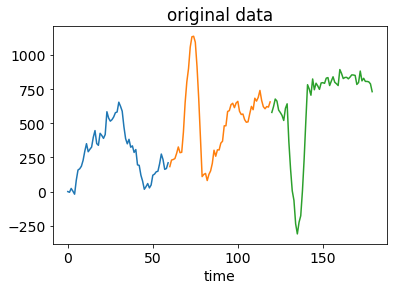

In [56]:
# random seed for reproducibility
np.random.seed(12345)

# pattern parameters: Z=nr of steps, A=amplitude
Z=12
Ampl = np.arange(200,1200, 200, dtype='int')
print(amplitudes)
# number of data samples
N=10000
# size of each sample of the timeseries
L=60
# step parameters: introduce small positive bias 
DX = 50
bias = 5

y = [0] * N
x = [[0] * L for i in range(N)]
for i in range(N):
    if i>0:
        x[i][0] = x[i-1][-1] + jump(bias,DX)
    
    for j in range(1,L):
        x[i][j] = x[i][j-1] + jump(bias,DX)
        
    y[i] = i%3 
    ##y[i] = random.randint(0,2)
    if y[i]>0:
        j0 = np.random.randint(0,L-1-Z)
        ###print(i,j0,j1)
        sign = 3-2*y[i]
        for j in range(Z):
            x[i][j0+j] += sign*pattern(j,Z,Ampl[4])
            
for i in range(min(3,N)):
    print(x[i],y[i])
    

Show_data(x,L,"original data")

In [57]:
str0 = f'ts_L{L}_Z{Z}_A500_DX{DX}_bias{bias}_N{N}.dat'
print(str0)

fname='DATA/x_A=1000'+str0
np.savetxt(fname,x,fmt="%d")
fname='DATA/y_A=1000'+str0
np.savetxt(fname,y,fmt="%d")

ts_L60_Z12_A500_DX50_bias5_N10000.dat


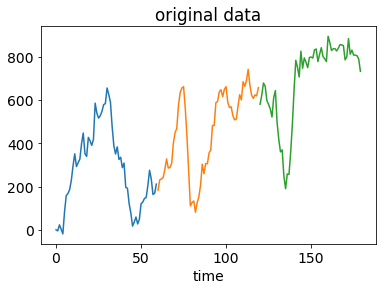

data:  10000


In [59]:

f200namex='DATA/x_'+str0 #'DATA/x_'+str0 'DATA/x_A=200'+str0, 'DATA/x_A=400'+str0 'DATA/x_A=1000'+str0
f200namey='DATA/y_'+str0 #'DATA/y_'+str0 'DATA/y_A=200'+str0, 'DATA/y_A=400'+str0 'DATA/y_A=1000'+str0


x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

Show_data(x,L,"original data")

categ = np.loadtxt(f200namey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1
print('data: ',N)

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

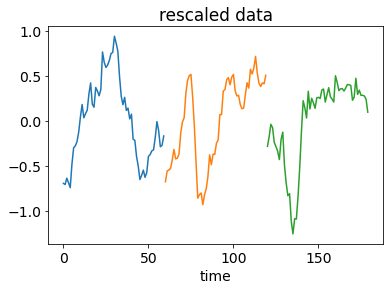

N_train= 8000   N_val= 2000   L= 60   n_class= 3


In [60]:
#
#  FIRST PASSAGE:  DO NOT DO THIS --> FAILURE 
#
#remove average value of each sample from its values
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]

#
#  SECOND PASSAGE:  DO NOT DO THIS --> ALSO FAILURE 
#
#rescale (crude version, variance should be used)
x = x/400
    
Show_data(x,L,"rescaled data")

perc_train=0.8
N_train = int(perc_train*N)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

#x_train=x_train.astype("float32")
#y_train=y_train.astype("float32")
#x_val=x_val.astype("float32")
#y_val=y_val.astype("float32")

# Keras wants an additional dimension with a 1 at the end
x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val =  x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)

In [61]:
# ...LESSON ...
# reproducibility
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)

## from keras import regularizers, initializers

reg = tf.keras.regularizers.l2(0.2) ## raised to 0.2
#reg = regularizers.l1(0.1)
ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, 
                                        seed=None)
NCONV = 1
NF = 5

# challenge: at most 600 tunable parameters
model = Sequential()
# 
if NCONV==1:
    # -----2-----
    model.add(Conv1D(filters=NF, kernel_size=11, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg,
                     activation='relu', 
                     input_shape=input_shape))
    #model.add(MaxPooling1D(3))
    model.add(AveragePooling1D(5))
    model.add(Conv1D(filters=5, kernel_size=7, 
                     activation='relu'))
    model.add(Flatten())
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(0.2))
# 
if NCONV==2:
    # -----1-----
    model.add(Conv1D(filters=NF, kernel_size=11, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg, ######## TRY WITHOUT !
                     activation='relu', input_shape=input_shape))
    #model.add(MaxPooling1D(3))
    model.add(AveragePooling1D(5))
    model.add(Flatten())
    model.add(Dense(9, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(6, activation='relu'))
    model.add(Dropout(0.2))
    #model.add(Dense(10, activation='relu'))
    #model.add(Dropout(0.3))
model.add(Dense(n_class, activation='softmax')) # softmax !

print('----- Model',NCONV,'-----')
print(model.summary())

# optimizers
# .SGD(lr=0.01, momentum=0.9, nesterov=True) # decay=1e-6,
# .RMSprop()
# .Nadam()
opt = tf.keras.optimizers.Adam()

# compile the model
# categorical_crossentropy, 3 output nodes
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,metrics=['accuracy'])

----- Model 1 -----
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 5)             60        
                                                                 
 average_pooling1d (AverageP  (None, 10, 5)            0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 5)              180       
                                                                 
 flatten (Flatten)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 12)                252       
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                    

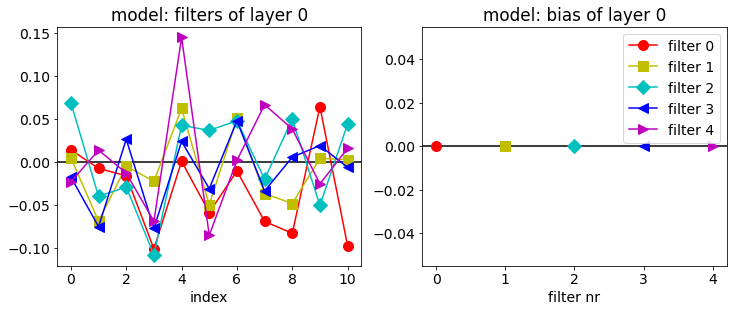

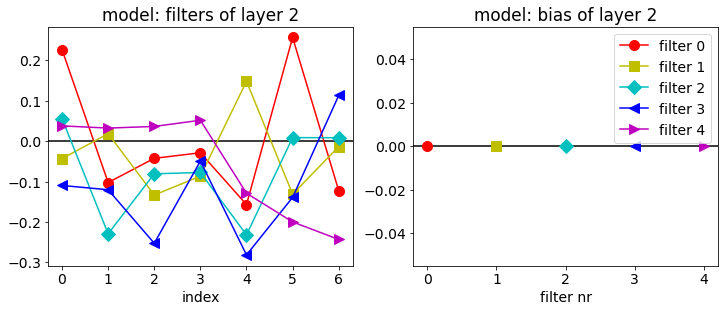

In [62]:
def Show_weights(model,l=0,label="model"):
    c=['r','y','c','b','m']
    m=['o','s','D','<','>']
    ms=10
    
    w = model.layers[l].get_weights()[0]
    wT=w.T
    M=len(wT)
    b = model.layers[l].get_weights()[1]
    
    fig,AX=plt.subplots(1,2,figsize=(12,4.4))
    ax=AX[0]
    ax.axhline(0, c="k")
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i][0],"-",c=c[i],marker=m[i],label=str(i),markersize=ms)
    ax.set_title(label+': filters of layer '+str(l))
    ax.set_xlabel('index')
    ax=AX[1]
    ax.axhline(0, c="k")
    for i in range(M):
        ax.plot((i),(b[i]),c=c[i],marker=m[i],label="filter "+str(i),markersize=ms)
    ax.set_title(label+': bias of layer '+str(l))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()
    plt.show()
    
Show_weights(model,0)
Show_weights(model,2)

In [63]:
# ...LESSON ...
# Hyper-parameters
# with small minibatch it does not converge!! 
BATCH_SIZE = 250
EPOCHS = 100

print('----- Model ',NCONV,'-----\nFITTING....')
fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=2, shuffle=True) 

----- Model  1 -----
FITTING....
Epoch 1/100
32/32 - 2s - loss: 1.1166 - accuracy: 0.3440 - val_loss: 1.1055 - val_accuracy: 0.3670 - 2s/epoch - 76ms/step
Epoch 2/100
32/32 - 0s - loss: 1.0984 - accuracy: 0.3943 - val_loss: 1.0893 - val_accuracy: 0.3910 - 425ms/epoch - 13ms/step
Epoch 3/100
32/32 - 0s - loss: 1.0744 - accuracy: 0.4755 - val_loss: 1.0572 - val_accuracy: 0.5305 - 396ms/epoch - 12ms/step
Epoch 4/100
32/32 - 0s - loss: 1.0298 - accuracy: 0.5691 - val_loss: 0.9961 - val_accuracy: 0.6545 - 409ms/epoch - 13ms/step
Epoch 5/100
32/32 - 0s - loss: 0.9681 - accuracy: 0.6121 - val_loss: 0.9174 - val_accuracy: 0.6825 - 409ms/epoch - 13ms/step
Epoch 6/100
32/32 - 0s - loss: 0.8852 - accuracy: 0.6556 - val_loss: 0.8287 - val_accuracy: 0.7190 - 426ms/epoch - 13ms/step
Epoch 7/100
32/32 - 0s - loss: 0.8130 - accuracy: 0.6775 - val_loss: 0.7522 - val_accuracy: 0.7420 - 458ms/epoch - 14ms/step
Epoch 8/100
32/32 - 0s - loss: 0.7538 - accuracy: 0.7045 - val_loss: 0.6927 - val_accuracy: 0.7

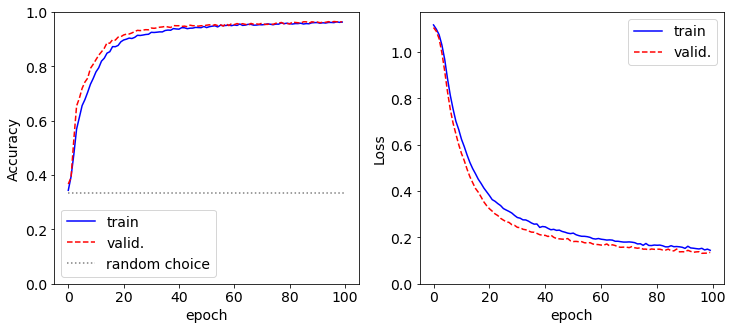

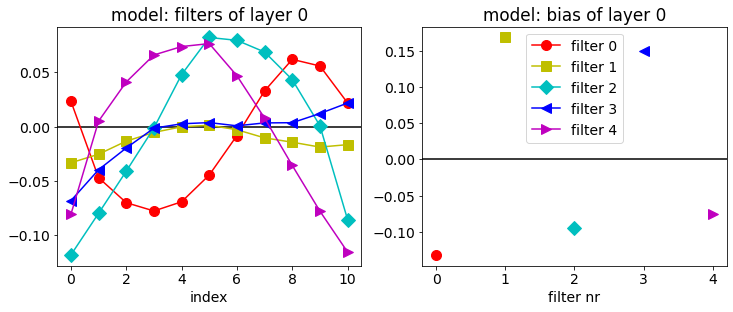

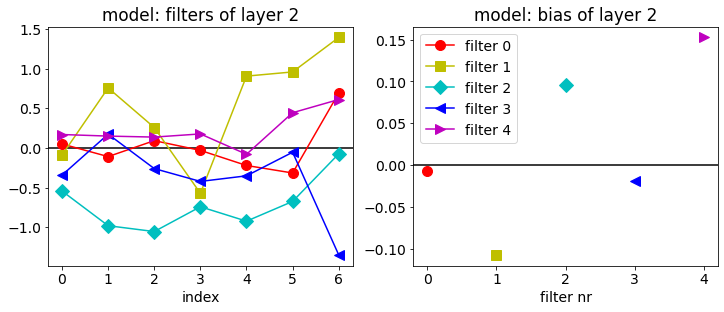

In [64]:
def Show_history(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()
Show_history(fit)
Show_weights(model,0)
Show_weights(model,2)

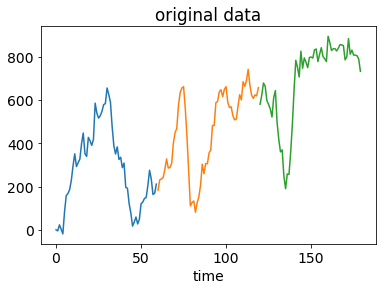

data:  10000


In [66]:

f400namex='DATA/x_'+str0 #'DATA/x_'+str0 'DATA/x_A=200'+str0, 'DATA/x_A=400'+str0 'DATA/x_A=1000'+str0
f400namey='DATA/y_'+str0 #'DATA/y_'+str0 'DATA/y_A=200'+str0, 'DATA/y_A=400'+str0 'DATA/y_A=1000'+str0


x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

Show_data(x,L,"original data")

categ = np.loadtxt(f200namey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1
print('data: ',N)

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

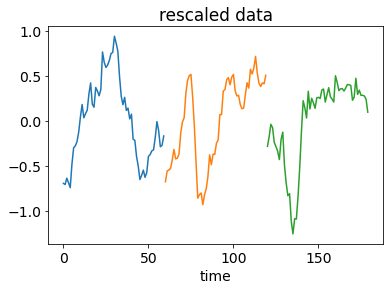

N_train= 8000   N_val= 2000   L= 60   n_class= 3


In [67]:
#
#  FIRST PASSAGE:  DO NOT DO THIS --> FAILURE 
#
#remove average value of each sample from its values
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]

#
#  SECOND PASSAGE:  DO NOT DO THIS --> ALSO FAILURE 
#
#rescale (crude version, variance should be used)
x = x/400
    
Show_data(x,L,"rescaled data")

x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

#x_train=x_train.astype("float32")
#y_train=y_train.astype("float32")
#x_val=x_val.astype("float32")
#y_val=y_val.astype("float32")

# Keras wants an additional dimension with a 1 at the end
x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val =  x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)

In [68]:
# ...LESSON ...
# Hyper-parameters
# with small minibatch it does not converge!! 
BATCH_SIZE = 250
EPOCHS = 100

print('----- Model ',NCONV,'-----\nFITTING....')
fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=2, shuffle=True) 

----- Model  1 -----
FITTING....
Epoch 1/100
32/32 - 0s - loss: 0.1441 - accuracy: 0.9639 - val_loss: 0.1292 - val_accuracy: 0.9655 - 388ms/epoch - 12ms/step
Epoch 2/100
32/32 - 0s - loss: 0.1483 - accuracy: 0.9613 - val_loss: 0.1316 - val_accuracy: 0.9655 - 378ms/epoch - 12ms/step
Epoch 3/100
32/32 - 0s - loss: 0.1448 - accuracy: 0.9636 - val_loss: 0.1305 - val_accuracy: 0.9665 - 450ms/epoch - 14ms/step
Epoch 4/100
32/32 - 0s - loss: 0.1468 - accuracy: 0.9619 - val_loss: 0.1288 - val_accuracy: 0.9635 - 412ms/epoch - 13ms/step
Epoch 5/100
32/32 - 0s - loss: 0.1440 - accuracy: 0.9634 - val_loss: 0.1276 - val_accuracy: 0.9655 - 432ms/epoch - 14ms/step
Epoch 6/100
32/32 - 0s - loss: 0.1472 - accuracy: 0.9621 - val_loss: 0.1342 - val_accuracy: 0.9615 - 365ms/epoch - 11ms/step
Epoch 7/100
32/32 - 0s - loss: 0.1403 - accuracy: 0.9653 - val_loss: 0.1408 - val_accuracy: 0.9625 - 424ms/epoch - 13ms/step
Epoch 8/100
32/32 - 0s - loss: 0.1413 - accuracy: 0.9655 - val_loss: 0.1278 - val_accuracy: 

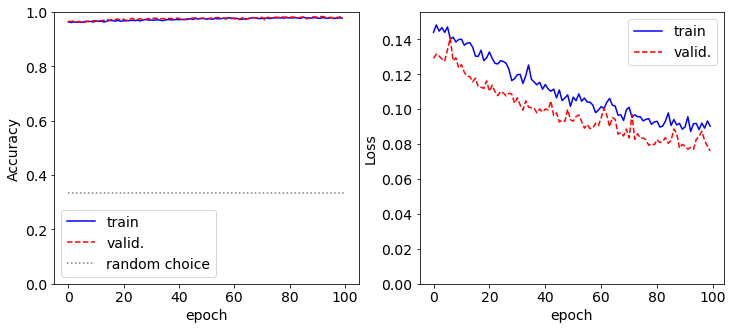

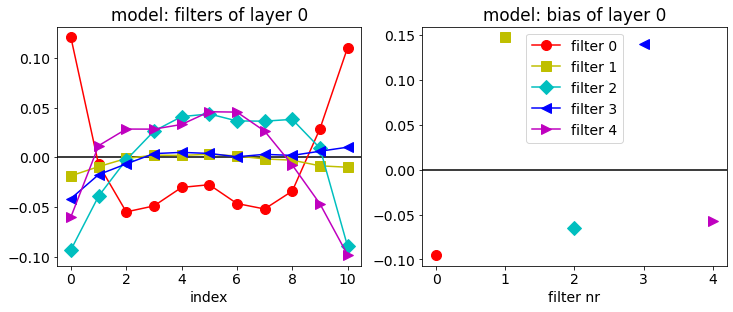

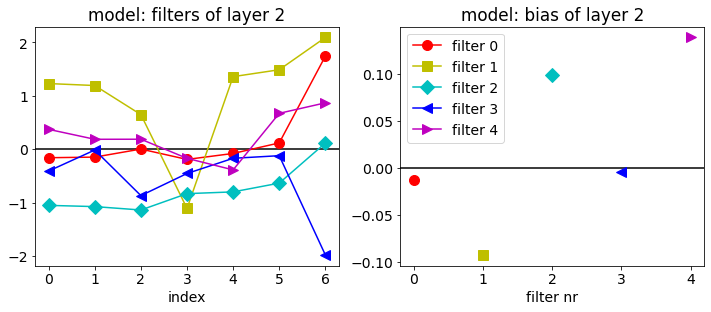

In [69]:
Show_history(fit)
Show_weights(model,0)
Show_weights(model,2)

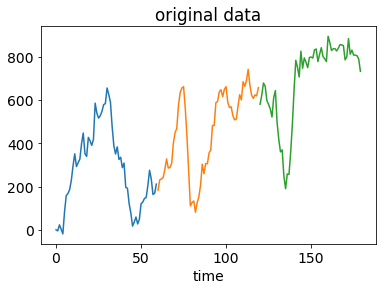

data:  10000


In [70]:

f1000namex='DATA/x_'+str0 #'DATA/x_'+str0 'DATA/x_A=200'+str0, 'DATA/x_A=400'+str0 'DATA/x_A=1000'+str0
f1000namey='DATA/y_'+str0 #'DATA/y_'+str0 'DATA/y_A=200'+str0, 'DATA/y_A=400'+str0 'DATA/y_A=1000'+str0


x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

Show_data(x,L,"original data")

categ = np.loadtxt(f200namey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1
print('data: ',N)

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

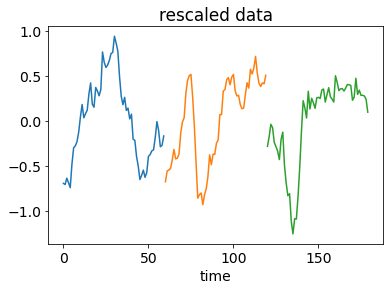

N_train= 8000   N_val= 2000   L= 60   n_class= 3


In [71]:
#
#  FIRST PASSAGE:  DO NOT DO THIS --> FAILURE 
#
#remove average value of each sample from its values
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]

#
#  SECOND PASSAGE:  DO NOT DO THIS --> ALSO FAILURE 
#
#rescale (crude version, variance should be used)
x = x/400
    
Show_data(x,L,"rescaled data")

x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

#x_train=x_train.astype("float32")
#y_train=y_train.astype("float32")
#x_val=x_val.astype("float32")
#y_val=y_val.astype("float32")

# Keras wants an additional dimension with a 1 at the end
x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val =  x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)

In [72]:
BATCH_SIZE = 250
EPOCHS = 100

print('----- Model ',NCONV,'-----\nFITTING....')
fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=2, shuffle=True) 

----- Model  1 -----
FITTING....
Epoch 1/100
32/32 - 0s - loss: 0.0865 - accuracy: 0.9803 - val_loss: 0.0784 - val_accuracy: 0.9815 - 380ms/epoch - 12ms/step
Epoch 2/100
32/32 - 0s - loss: 0.0914 - accuracy: 0.9785 - val_loss: 0.0767 - val_accuracy: 0.9830 - 335ms/epoch - 10ms/step
Epoch 3/100
32/32 - 0s - loss: 0.0950 - accuracy: 0.9769 - val_loss: 0.0814 - val_accuracy: 0.9800 - 362ms/epoch - 11ms/step
Epoch 4/100
32/32 - 0s - loss: 0.0935 - accuracy: 0.9778 - val_loss: 0.0737 - val_accuracy: 0.9825 - 392ms/epoch - 12ms/step
Epoch 5/100
32/32 - 0s - loss: 0.0894 - accuracy: 0.9799 - val_loss: 0.0808 - val_accuracy: 0.9825 - 411ms/epoch - 13ms/step
Epoch 6/100
32/32 - 0s - loss: 0.0948 - accuracy: 0.9765 - val_loss: 0.0893 - val_accuracy: 0.9785 - 399ms/epoch - 12ms/step
Epoch 7/100
32/32 - 0s - loss: 0.0864 - accuracy: 0.9811 - val_loss: 0.0899 - val_accuracy: 0.9765 - 414ms/epoch - 13ms/step
Epoch 8/100
32/32 - 0s - loss: 0.0905 - accuracy: 0.9780 - val_loss: 0.0866 - val_accuracy: 

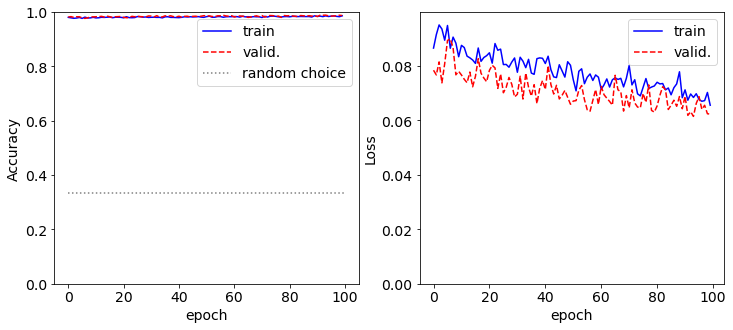

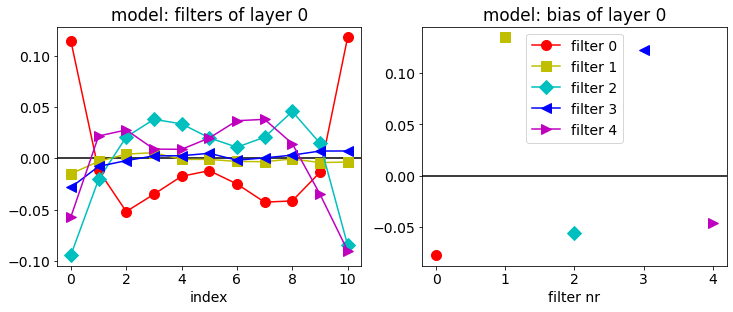

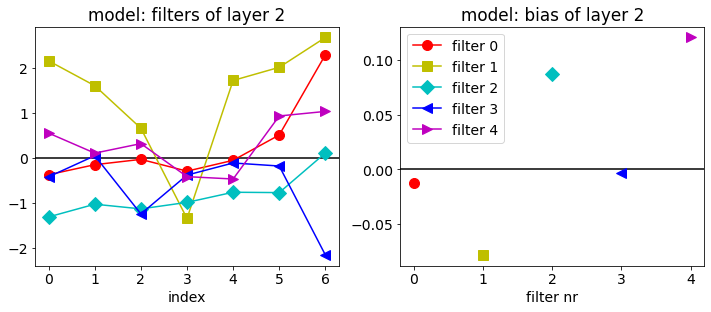

In [73]:
Show_history(fit)
Show_weights(model,0)
Show_weights(model,2)